In [1]:
import time
import torch
import torch.nn as nn

from tqdm.notebook import tqdm as tqdm_nb


import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.utils as vutils
import seaborn as sns

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")

print(device)

mps


In [2]:
workers = 0
image_size = 64
batch_size=128

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator

# Number of channels in the training images. For color images this is 3
nc = 3

ndf = 64

# Nubmer of loop to train ciritic
n_critics = 5

lr = 0.0001

weight_cliping_limit = 0.01

imageDir="./archive/data0/lsun/bedroom"

fixed_noise = torch.randn(64, nz, 1, 1, device=device)


In [3]:
dataset = datasets.ImageFolder(root=imageDir,
                                transform=T.Compose([
                                    T.Resize(image_size),
                                    T.CenterCrop(image_size),
                                    T.ToTensor(),
                                    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

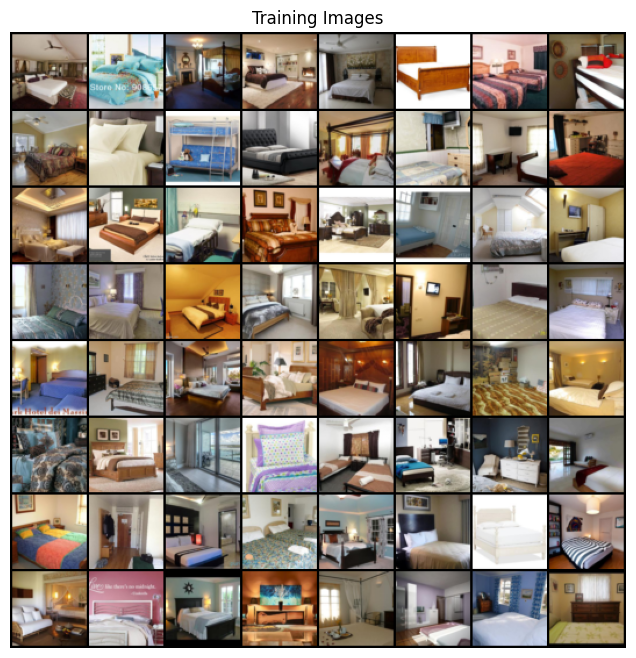

In [4]:
one_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(one_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [5]:
class SaveCheckpoint:
    def __init__(self, path = None):
        self.loss = np.inf
        self.path = path or os.path.join('.')
    
    def update(self, model, loss):
        if self.loss > loss:
            self.loss = loss
            self.save(model)

    def save(self, model, name):
        if isinstance(model, nn.Module):
            model = [model]
            name = [name]
        for m, n in zip(model, name):
            torch.save(m.state_dict(), '{}/{}.pth'.format(self.path, n))

In [6]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [10]:
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)



Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [11]:
optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

In [17]:
num_epochs = 3

In [19]:
img_list = []
G_losses = []
D_losses = []

total_steps = num_epochs * len(dataloader)
fig_save_interval = total_steps // 20  # animation can contain max 36 images

pbar = tqdm_nb()
piter = 0

#checkpoint = SaveCheckpoint()

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    #print("Epoch: " +str(epoch))
    # For each batch in the dataloader
    pbar.reset(total=len(dataloader))
    for i, data in enumerate(dataloader, 0):
        pbar.update()
        piter += 1
        ################################################################
        # (1) Update D network: maximize D(x) + D(G(z)) 5 times
        ################################################################
        ## Train with all-real batch
        netD.zero_grad()
        
        real_img = data[0].to(device)
        b_size = real_img.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_img = netG(noise)
        
        errD = -torch.mean(netD(real_img)) + torch.mean(netD(fake_img)) # Wasserstein
        errD.backward()
        optimizerD.step()
        
        # Clip weights of discriminator
        for p in netD.parameters():
            p.data.clamp_(-weight_cliping_limit, weight_cliping_limit)
        
        # Train Generator for every 5 steps
        if i % n_critics == 0:
            ################################################################
            # (2) Update G network: maximize D(G(z)
            ################################################################
            netG.zero_grad()

            gen_img = netG(noise)
            errG = -torch.mean(netD(gen_img))
            errG.backward()
            optimizerG.step()

            # Output training stats
            desc = '[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' \
                    % (epoch+1, num_epochs, i, len(dataloader), errD.item(), errG.item())
            pbar.set_description(desc)

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (piter - 1) % fig_save_interval == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                
            img_list.append((epoch+1, i, vutils.make_grid(fake, padding=2, normalize=True)))
            print(desc)

pbar.refresh()

#checkpoint.save([netG, netD], ['LSUN_netG', 'LSUN_netD'])

0it [00:00, ?it/s]

Starting Training Loop...
[1/3][0/2369] Loss_D: -1.3687 Loss_G: 0.6668
[1/3][355/2369] Loss_D: -1.2920 Loss_G: 0.6397


In [ ]:
plt.figure(figsize=(10, 5))
plt.title("[LSUN] Generator and Discriminator Loss During Training")
df = pd.DataFrame({'G': G_losses, 'D': D_losses})
ax1 = sns.lineplot(data=df, x=df.index, y='G', label='G', color='royalblue', alpha=.75)
ax2 = ax1.twinx()
sns.lineplot(data=df, x=df.index, y='D', label='D', color='orange', alpha=.75, ax=ax2)
for ax in [ax1, ax2]:
#     ax.set_ylim(bottom=0.)
    ax.legend([])
ax1.figure.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.axis('off')
imgs = [[
    plt.imshow(np.transpose(img, (1,2,0)), animated=True),
    plt.text(0.5, 1.01, f'{step} iteration of {epoch} epoch', horizontalalignment='center', transform=ax.transAxes),
] for epoch, step, img in img_list]

ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())